1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

4. Shrinkage Method를 다르게

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ray

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from optimize_multi.backtest import simulate_strategy

from ryu_tool.mytool import draw_return_result, print_statistics, run_alpha_regression

2023-05-12 20:01:24,436	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
# 필요한 데이터 불러오기
price = pd.read_pickle("Data/allstock_adj.pickle")
rtn = price.pct_change(fill_method=None)

spx_mask = pd.read_pickle("Data/spx_mask.pickle")

In [3]:
# Ray를 사용하기 위해 Ray데이터 생성
rtn_ray = ray.put(rtn)
mask_ray = ray.put(spx_mask)

In [4]:
# S&P500 마켓 데이터 (결과 비교를 위해)
spx = pd.read_csv("Data/spx_hist.csv", 
                  index_col=0,
                  parse_dates=True).pct_change(fill_method=None)

# Investing.com에서 받아와서 그런지 Timestamp에 문제가 있다
problem = [pd.Timestamp('2021-07-03 00:00:00'),
           pd.Timestamp('2021-07-04 00:00:00'),
           pd.Timestamp('2021-07-05 00:00:00'),
           pd.Timestamp('2021-08-07 00:00:00'),
           pd.Timestamp('2021-08-08 00:00:00')]

spx = spx.drop(problem)

In [5]:
look_back_list = [60, 120, 180, 240, 300, 365]

In [26]:
look_back_list2 = [90,100, 110, 120]

In [34]:
args_lst = [0.1, 1, 3, 5, 10, 20]

In [35]:
futures = [run_optimizer.remote(obj_function=obj_sharpe, 
                                rtn_df=rtn_ray,
                                spx_mask=mask_ray,
                                start_year="2006",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=150,
                                max_ratio=1,
                                shrinkage_method="clipping",
                                arg=arg)  for arg in args_lst]
result = ray.get(futures)

100%|██████████| 68/68 [20:56<00:00, 18.48s/it] [repeated 3x across cluster]


In [37]:
result_dict = {}
weight_dict = {}

for i, arg in enumerate(args_lst):
    rt, weig = simulate_strategy(result[i], rtn, fee_rate=0)
    result_dict[f"Eigenvalue Clipping / Alpha={arg} / Look Back 150 days"] = rt
    weight_dict[str(arg)] = weig

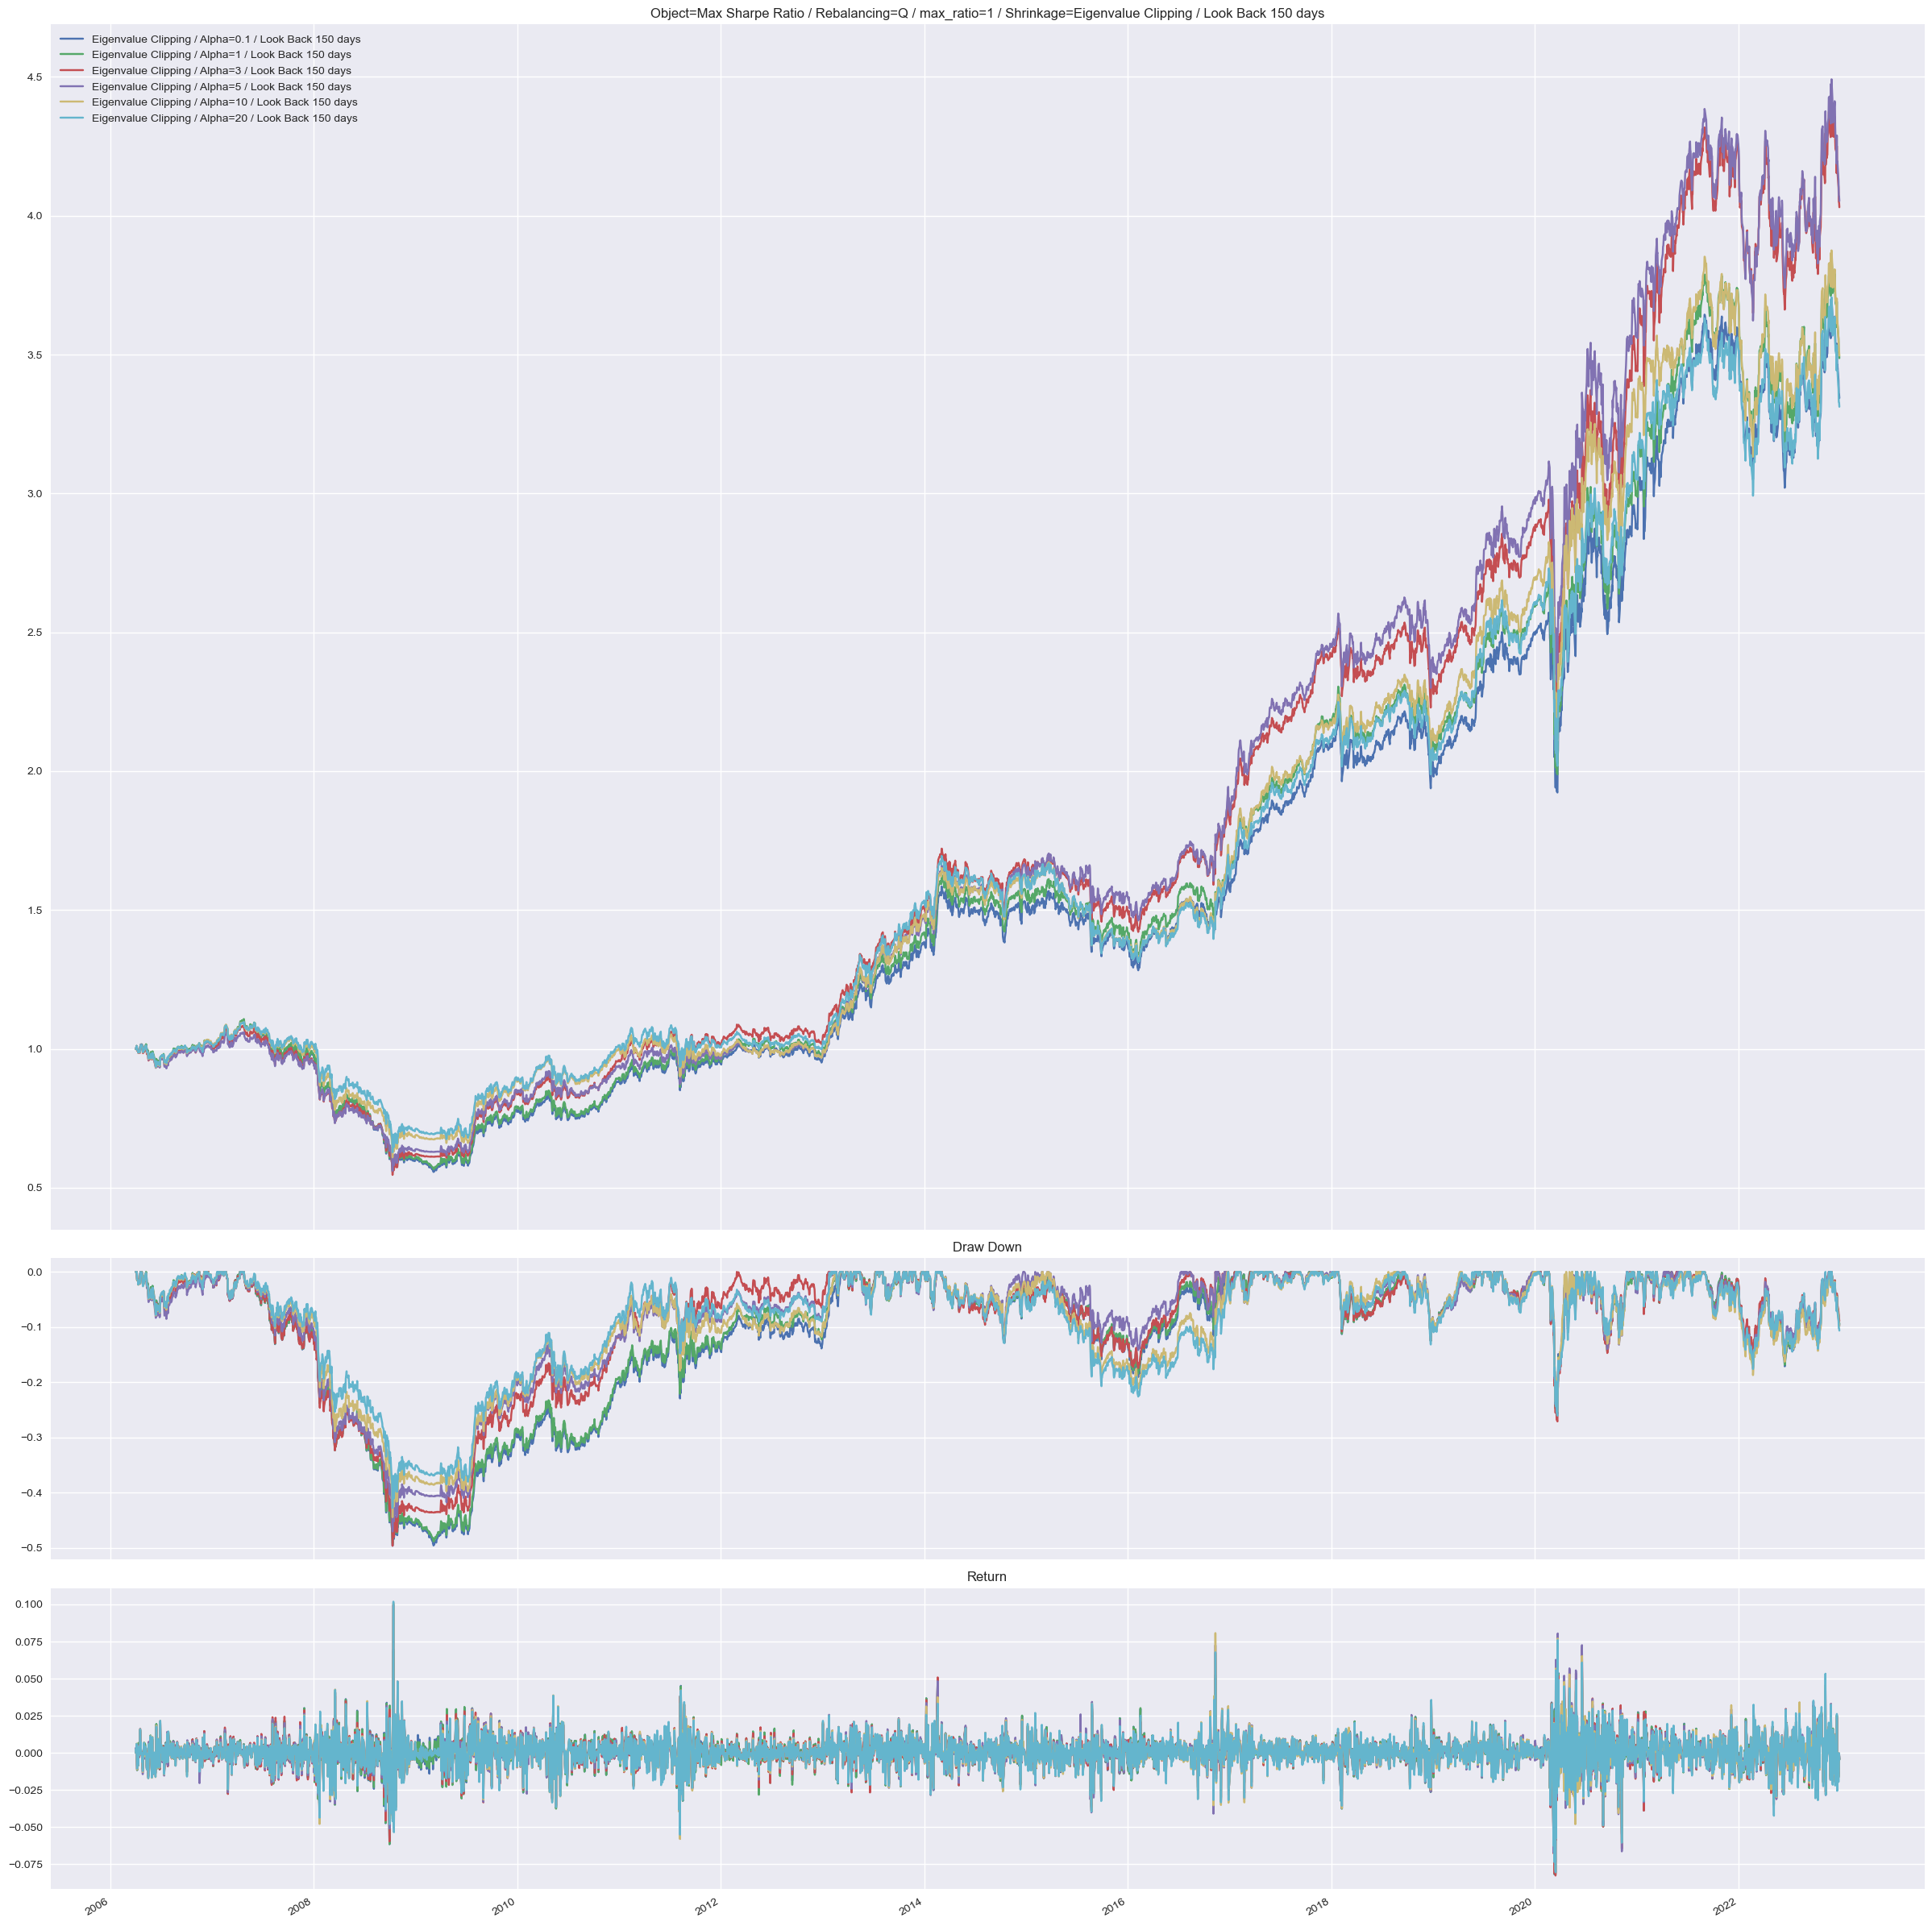

In [38]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Object=Max Sharpe Ratio / Rebalancing=Q / max_ratio=1 / Shrinkage=Eigenvalue Clipping / Look Back 150 days")

In [39]:
stats = print_statistics(result_dict)
stats.columns = [f"alphh={day}" for day in args_lst]
stats

,alphh=0.1,alphh=1,alphh=3,alphh=5,alphh=10,alphh=20
CAGR,0.074000,0.076700,0.086000,0.086300,0.076900,0.073400
Mean,0.123770,0.127480,0.140990,0.140950,0.127790,0.123450
STD,0.196219,0.196560,0.201588,0.199022,0.197138,0.198864
MDD,0.496000,0.492000,0.496000,0.470000,0.444000,0.428000
Sharpe,0.630775,0.648554,0.699398,0.708213,0.648225,0.620776


Text(0.5, 1.0, 'Sharpe / Q / max_ratio=1 / shrinkage=Eigen Value Clipping (Alpha=5) / Look Back Window = 150 days')

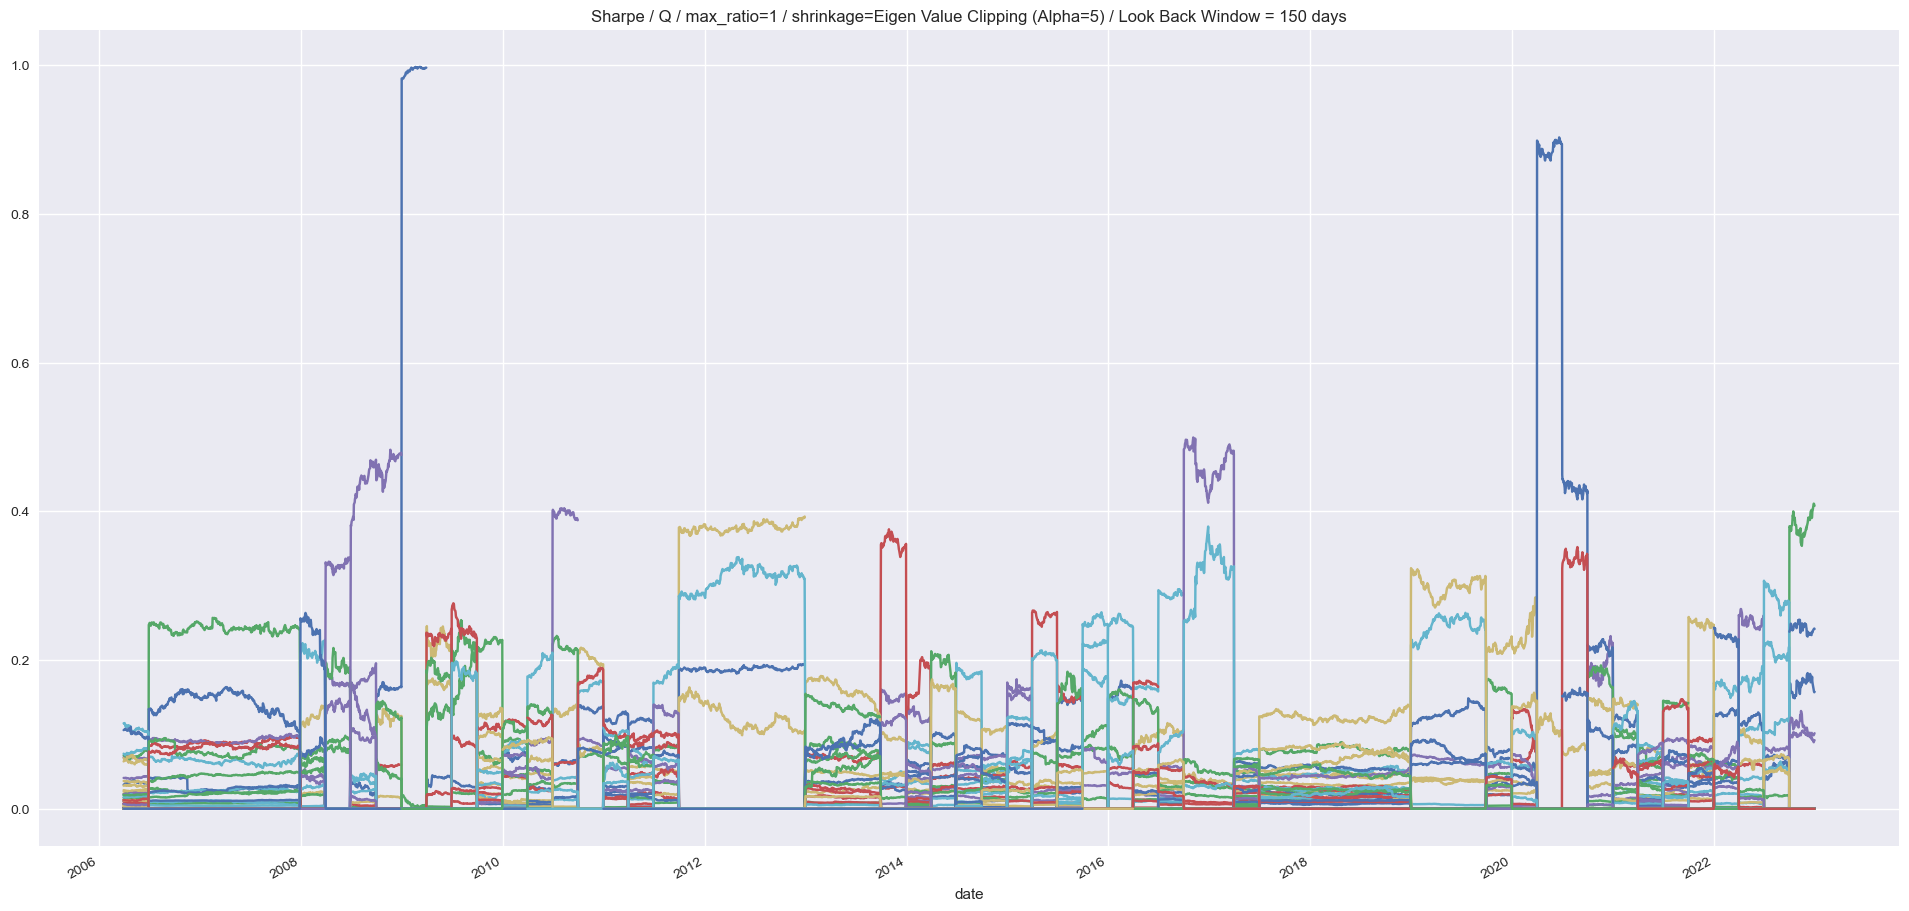

In [42]:
weight_dict["5"].plot(figsize=(24,12),
                        legend=False)
plt.title("Sharpe / Q / max_ratio=1 / shrinkage=Eigen Value Clipping (Alpha=5) / Look Back Window = 150 days")

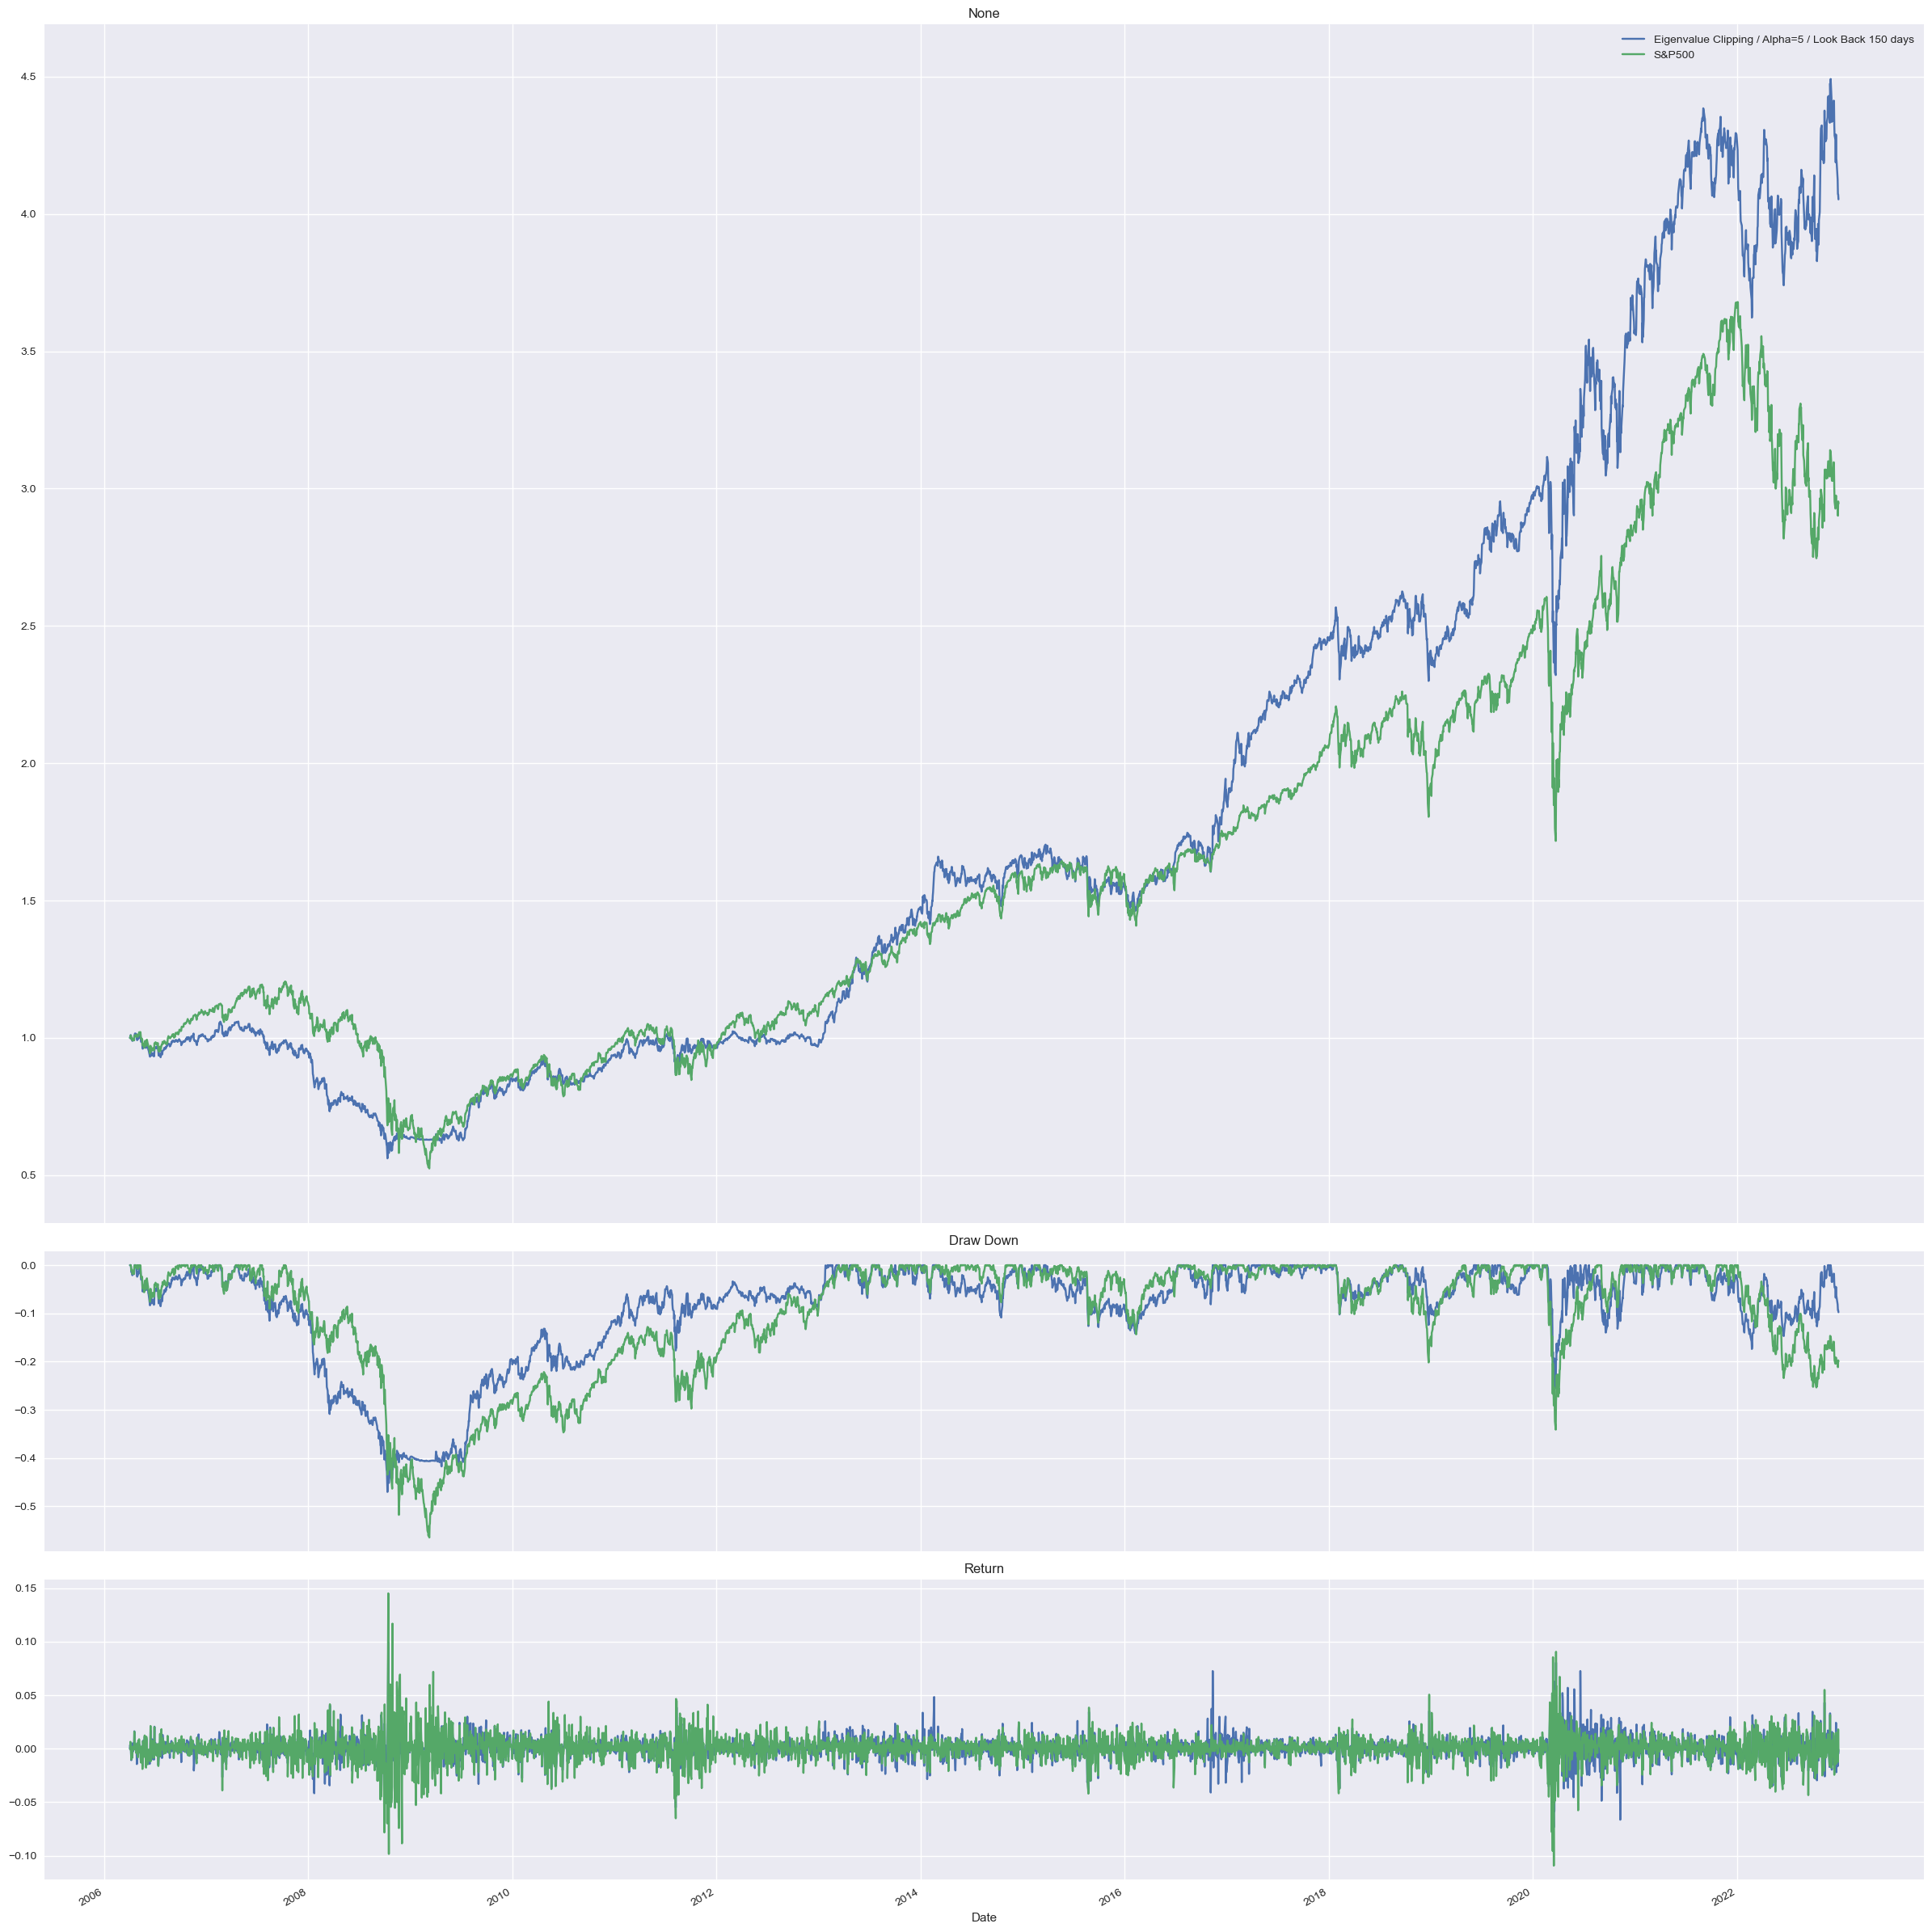

In [44]:
portfolio = result_dict["Eigenvalue Clipping / Alpha=5 / Look Back 150 days"]
spx_sample = spx.loc[portfolio.index[0]:]["Price"] # Series로 변경

draw_return_result({"Eigenvalue Clipping / Alpha=5 / Look Back 150 days":portfolio,
                    "S&P500": spx_sample},
                   one_plot=True)

In [47]:
st = print_statistics({"Eigenvalue Clipping / Alpha=5 / Look Back 150 days":portfolio,
                       "S&P500": spx_sample})
st.columns = ["Eigenvalue Clipping","S&P500"]
st

,Eigenvalue Clipping,S&P500
CAGR,0.086300,0.065800
Mean,0.140950,0.123110
STD,0.199022,0.242743
MDD,0.470000,0.565000
Sharpe,0.708213,0.507161


In [49]:
run_alpha_regression({"Eigenvalue Clipping":portfolio.iloc[1:]},
                     mkt_rtn=spx_sample)

Eigenvalue Clipping Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.440      
Dependent Variable: y                AIC:                -28963.4294
Date:               2023-05-13 00:37 BIC:                -28950.7361
No. Observations:   4216             Log-Likelihood:     14484.     
Df Model:           1                F-statistic:        3313.      
Df Residuals:       4214             Prob (F-statistic): 0.00       
R-squared:          0.440            Scale:              6.0781e-05 
-----------------------------------------------------------------------
           Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
-----------------------------------------------------------------------
const      0.0002      0.0001     1.6812    0.0928    -0.0000    0.0004
Price      0.5440      0.0095    57.5605    0.0000     0.5255    0.5625
--------------------------------------------------------------------
